# Data 144 Final Project

Keilyn Yuzuki

Data Source: https://www.kaggle.com/mariaren/covid19-healthy-diet-dataset

**Question:** How does the diet of different countries affect COVID-19 death rates?

Real-life connections:

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.feature_extraction import DictVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

pd.set_option('display.max_rows', None)

## Data Cleaning
Combining the 4 individual datasets into one.

Things to note:
- the columns `obesity`, `undernourished`, `confirmed`, `deaths`, `recovered`, `active`, `population`, and `unit_all_except_population` are the same between all 4 tables. In the final dataframe only one copy of these columns is retained.

In [2]:
def clean_column_names(df):
    old_names = df.columns
    new_names = df.columns.str.lower().str.replace(' -', '').str.replace(',','').str.replace('(','').str.replace(')','').str.replace(' ','_')
    name_dict = {}
    for a,b in zip(old_names, new_names):
        name_dict[a] = b
    df = df.rename(columns=name_dict)
    return df    

In [3]:
def load_clean_data(file, ignore_covid_stats=True):
    df = pd.read_csv(file)
    df = clean_column_names(df)
    if ignore_covid_stats:
        df = df.drop(['obesity', 'undernourished', 'confirmed', 'deaths', 'recovered', 'active', 'population', 'unit_all_except_population'], axis=1)
    return df
        

In [155]:
food_kcal = load_clean_data('data/Food_Supply_kcal_Data.csv')
food_kg = load_clean_data('data/Food_Supply_Quantity_kg_Data.csv')
fat = load_clean_data('data/Fat_Supply_Quantity_Data.csv')
protein = load_clean_data('data/Protein_Supply_Quantity_Data.csv', ignore_covid_stats=False)

food = food_kcal.merge(food_kg, how='inner', on='country', suffixes=['_food_kcal', '_food_kg'])
fat_protein = fat.merge(protein, how='inner', on='country', suffixes=['_fat', '_protein'])
combined = food.merge(fat_protein, how='inner', on='country')

df = combined.loc[:, 'country':'miscellaneous_protein']
df['confirmed'] = combined['confirmed']
df = df.dropna()
df

,country,alcoholic_beverages_food_kcal,animal_products_food_kcal,animal_fats_food_kcal,aquatic_products_other_food_kcal,cereals_excluding_beer_food_kcal,eggs_food_kcal,fish_seafood_food_kcal,fruits_excluding_wine_food_kcal,meat_food_kcal,...,starchy_roots_protein,stimulants_protein,sugar_crops_protein,sugar_&_sweeteners_protein,treenuts_protein,vegetal_products_protein,vegetable_oils_protein,vegetables_protein,miscellaneous_protein,confirmed
0,Afghanistan,0.0000,4.7774,0.8504,0.0000,37.1186,0.1501,0.0000,1.4757,1.2006,...,0.1941,0.5546,0.0000,0.0000,0.1387,40.2477,0.0000,1.1370,0.0462,0.108128
1,Albania,0.9120,16.0930,1.0591,0.0000,16.2107,0.8091,0.1471,3.8982,3.8688,...,0.8867,0.2635,0.0000,0.0042,0.2677,22.2552,0.0084,3.2456,0.0544,0.852925
2,Algeria,0.0896,6.0326,0.1941,0.0000,25.0112,0.4181,0.1195,3.1805,1.2543,...,1.4638,0.4628,0.0000,0.0000,0.2745,36.1694,0.0269,3.1267,0.1399,0.139890
3,Angola,1.9388,4.6927,0.2644,0.0000,18.3521,0.0441,0.8372,2.3133,2.9302,...,5.1941,0.1017,0.0000,0.0092,0.0092,34.7782,0.0092,0.8133,0.0924,0.038230
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0000,13.7215,0.2057,1.7280,3.6824,7.0356,...,0.4666,0.4113,0.0000,0.0000,0.0737,16.8161,0.0430,1.6024,0.2947,0.133673
5,Argentina,1.4354,14.9869,1.0650,0.0000,16.7927,0.8643,0.2006,1.4663,9.4459,...,1.3096,0.9688,0.0000,0.0049,0.0438,18.0176,0.0000,1.0516,0.0000,2.737471
6,Armenia,0.2274,12.8330,1.7706,0.0000,19.2658,0.7310,0.1787,2.5341,4.2235,...,0.9191,0.5545,0.0000,0.0051,0.2208,27.1154,0.0205,4.6621,0.1078,3.600271
7,Australia,1.9783,15.6146,1.9027,0.0000,11.6430,0.4681,0.6040,1.6611,7.4902,...,0.9944,0.7031,0.0000,0.0000,0.7724,17.0213,0.0463,1.4524,0.2174,0.107420
8,Austria,2.8161,15.6106,5.2532,0.0000,12.3748,0.7853,0.4062,1.5976,5.0095,...,1.0450,0.7260,0.0000,0.0139,0.3561,19.9991,0.0647,1.5259,0.0000,1.718118
9,Azerbaijan,2.2555,8.1682,1.3050,0.0000,28.7417,0.5478,0.0967,1.6111,2.9322,...,1.7652,0.2328,0.0000,0.0000,0.3411,33.7015,0.0217,1.9114,0.0433,0.647121


In [156]:
X = normalize(df.loc[:, 'alcoholic_beverages_food_kcal':'miscellaneous_protein'].to_numpy(), axis=0)
y = df.loc[:, 'confirmed']

In [157]:
scaler = MinMaxScaler()
y = scaler.fit_transform(y.values.reshape(-1,1)).reshape(162)

## Preliminary Data Visualization

In [147]:
animal_products = df[['animal_products_fat', 'animal_products_protein', 'animal_products_food_kcal', 'animal_products_food_kg']]

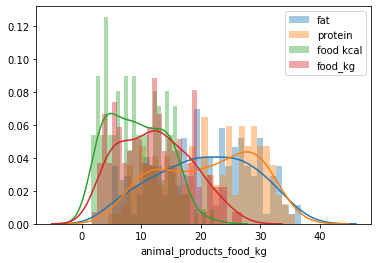

In [148]:
sns.distplot(animal_products['animal_products_fat'], bins=30, label='fat')
sns.distplot(animal_products['animal_products_protein'], bins=30, label='protein')
sns.distplot(animal_products['animal_products_food_kcal'], bins=30, label='food kcal')
sns.distplot(animal_products['animal_products_food_kg'], bins=30, label='food_kg')
plt.legend();

## Modeling

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

The following 5 cells were used to test for deaths.

In [150]:
clf = MLPRegressor(hidden_layer_sizes=(10), max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination: -0.25574857600144685
MSE: 0.04994270196386524


In [151]:
clf = MLPRegressor(hidden_layer_sizes=(50, 25, 10), activation = 'relu', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination: 0.175388499476532
MSE: 0.03279583763316313


In [152]:
clf = MLPRegressor(hidden_layer_sizes=(50, 25, 10), activation = 'logistic', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination: -0.00846688830762754
MSE: 0.04010799789520635


In [153]:
clf = MLPRegressor(hidden_layer_sizes=(50, 25, 10), activation = 'logistic', solver = 'lbfgs', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination: -0.004982452612247501
MSE: 0.039969417500394566


In [154]:
clf = MLPRegressor(hidden_layer_sizes=(750, 500, 250, 100, 50), 
                   activation = 'logistic', solver = 'lbfgs', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination: -0.004963839414607652
MSE: 0.0399686772300888


In [139]:
# for confirmed cases

In [158]:
clf = MLPRegressor(hidden_layer_sizes=(50, 25, 10), activation = 'relu', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination: 0.175388499476532
MSE: 0.03279583763316313


In [184]:
clf = MLPRegressor(hidden_layer_sizes=(200, 175, 150, 125, 75), activation = 'relu', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination, Train:", clf.score(X_train, y_train))
print("Coefficient of Determination, Test:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination, Train: 0.9877899715099137
Coefficient of Determination, Test: 0.4723723457584583
MSE: 0.0209844161381301


In [195]:
clf = MLPRegressor(hidden_layer_sizes=(200, 175, 150, 125, 75), activation = 'tanh', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination, Train:", clf.score(X_train, y_train))
print("Coefficient of Determination, Test:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination, Train: 0.32424798227760765
Coefficient of Determination, Test: 0.22577570539931427
MSE: 0.030791875011754972


In [197]:
for s in ['lbfgs', 'sgd', 'adam']:
    for a in ['identity', 'logistic', 'tanh', 'relu']:
        print(s, a)
        clf = MLPRegressor(hidden_layer_sizes=(200, 175, 150, 125, 75), activation = a, solver=s, max_iter=2000, random_state=42)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        print("Coefficient of Determination, Train:", clf.score(X_train, y_train))
        print("Coefficient of Determination, Test:", clf.score(X_test, y_test))
        print("MSE:", mean_squared_error(y_test, y_pred))
        print("")

lbfgs identity
Coefficient of Determination, Train: 0.5843063977400982
Coefficient of Determination, Test: -0.903515067858419
MSE: 0.07570519093916948

lbfgs logistic
Coefficient of Determination, Train: 4.1355119743125e-06
Coefficient of Determination, Test: -0.004957811833397274
MSE: 0.03996843750559482

lbfgs tanh
Coefficient of Determination, Train: 0.9938325805013243
Coefficient of Determination, Test: -28.71539610690723
MSE: 1.1818187174307089

lbfgs relu
Coefficient of Determination, Train: 0.9998571649520368
Coefficient of Determination, Test: -4.258554318260768
MSE: 0.20913932621285447

sgd identity
Coefficient of Determination, Train: -0.021704676035345205
Coefficient of Determination, Test: 0.08590359931785263
MSE: 0.03635476478171839

sgd logistic
Coefficient of Determination, Train: -0.37768707242000715
Coefficient of Determination, Test: -0.3399104374537536
MSE: 0.053289925160901

sgd tanh
Coefficient of Determination, Train: -0.02924293340931428
Coefficient of Determinat

## Visualization

In [198]:
clf = MLPRegressor(hidden_layer_sizes=(200, 175, 150, 125, 75), activation = 'relu', max_iter=2000, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Coefficient of Determination, Train:", clf.score(X_train, y_train))
print("Coefficient of Determination, Test:", clf.score(X_test, y_test))
print("MSE:", mean_squared_error(y_test, y_pred))

Coefficient of Determination, Train: 0.9877899715099137
Coefficient of Determination, Test: 0.4723723457584583
MSE: 0.0209844161381301


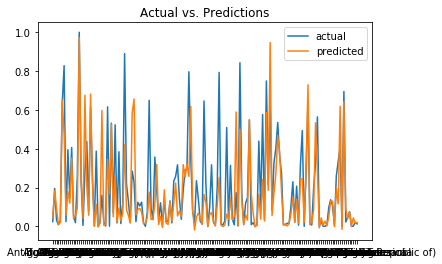

In [199]:
plt.plot(df['country'], y, label='actual')
plt.plot(df['country'], clf.predict(X), label='predicted')
plt.legend()
plt.title('Actual vs. Predictions');